<a href="https://colab.research.google.com/github/sh-Gabriel/Atrial-Enlargement-Detection/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
from google.colab         import drive
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
from   matplotlib          import pyplot
# from google.colab.patches import cv2_imshow

import numpy as np
from   numpy import expand_dims

import pandas as pd
import cv2    as cv
import random
import os
import glob
import csv

from io import BytesIO

from PIL import Image

from itertools import islice

import tensorflow                as tf
from   tensorflow                import keras, numpy_function
from   tensorflow.keras.utils    import load_img, img_to_array
from   tensorflow.image          import adjust_contrast

import tensorflow_addons as tfa

#from   tensorflow.keras.preprocessing.image import img_to_array

from keras                     import layers 
from keras.callbacks           import EarlyStopping,ModelCheckpoint
from keras.applications.vgg16  import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

from sklearn                 import metrics, svm
from sklearn.utils           import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import ConfusionMatrixDisplay
from sklearn.metrics         import confusion_matrix

#augmentation
import matplotlib.pyplot as plt

# import mxnet                   as mx
# from   mxnet.gluon.data.vision import transforms

from sklearn.model_selection import KFold

#!pip3 install tensorflow-addons

In [ ]:
#mount and defines

# drive.mount('/content/drive/MyDrive/TCC/',force_remount=True)
drive.mount('/content/drive',force_remount=True)
PATH             = 'drive/MyDrive/TCC/Dataset_V1/'
norm             = "N"
doente           = "AAE_EP"
left             = "Torax_LAT_E"
right            = "Torax_LAT_D"
stop_n = stop_s  = 30 # voltei pra 6 pra fazer os testes
current_s        = 6
# Imagem é mto grande para ser alocada na gpu, não dá pra usar esses valores
# shape_w, shape_h = 2928, 2328
shape_w, shape_h = 224,224
EPOCHS           = 12
number_of_folds  = 4 #4-fold cross validation + holdout set
np.random.seed(42)
# !git clone https://github.com/pjreddie/darknet.git
# !cd drive/MyDrive/TCC/darknet; make
!nvidia-smi --query-gpu=memory.total --format=csv
!nvidia-smi

Mounted at /content/drive
memory.total [MiB]
15109 MiB
Thu Nov 24 16:39:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

Coloquei os defs e a chamada do join_open_files tudo junto, porque basicamente eles fazem uma coisa só que é o join_open_files e assim, não precisa ficar rodando os defs de novo toda vez que muda alguma coisa

In [ ]:
def rotation(img):
  dim = img.shape[:2]
  center = (dim[0]/2, dim[1]/2)
  rot = cv.getRotationMatrix2D(center, 15, 1)
  rotated = cv.warpAffine(img, rot,dim)
  return rotated

def translation(img):
  T = np.float32([[1, 0, 0], [0, 1, -50]])
  translated = cv.warpAffine(img, T, img.shape[:2])
  return translated

def enbrighten(img):
  sam = expand_dims(img, 0)
  imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.9,0.9])
  iterator = imageDataGenerator_obj.flow(sam, batch_size=1)
  result = iterator.next()[0].astype('uint8')
  return result

def change_contrast(img):
  contrast = tf.keras.layers.RandomContrast(0.3, seed = 42)
  # cv2_imshow(contrast(img).numpy().astype('uint8'))
  imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.2,1.0])
  return contrast(img).numpy().astype('uint8')

In [ ]:
def openImgs(classe,lateralidade):
  r_v = [] 
  for subdir, dirs, files in os.walk(PATH+classe):
    if (files and lateralidade in subdir):
      r_v += [subdir+'/'+files[0]]
  return shuffle(r_v, random_state = 42)

def join(lateralidade=left):
  X=[] # Images
  Y=[] # type of image (normal or AE)

  for f in islice(openImgs(norm, lateralidade), 0, stop_n):
      X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'normal'
      Y += [0]

  for f in islice(openImgs(doente, lateralidade), 0, current_s):
      X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'atrial enlargement'

      X.append( cv.resize( (rotation(cv.imread(f)) )       , (shape_w, shape_h) ) ) #data augmentation
      X.append( cv.resize( (translation(cv.imread(f)) )    , (shape_w, shape_h) ) )
      X.append( cv.resize( (enbrighten(cv.imread(f))  )    , (shape_w, shape_h) ) )
      X.append( cv.resize( (change_contrast(cv.imread(f)) ), (shape_w, shape_h) ) )
      
      Y += [1]*5
  return np.array(X), np.array(Y)

X, y = join()
X.shape

(60, 224, 224, 3)

In [ ]:
def custom_VGG16():
  vgg16 = keras.applications.VGG16(input_shape=(shape_h, shape_w, 3), include_top=False, weights="imagenet", classes=2);

  last_layer = vgg16.get_layer('block5_pool')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)
  
  vgg16 = keras.Model(vgg16.input, extraLayer)
  
  return vgg16
  
model = custom_VGG16()
model.summary() 

In [ ]:
def custom_VGG19():
  vgg19 = keras.applications.VGG19(input_shape=(shape_h, shape_w, 3), include_top=False, weights="imagenet", classes=2);

  last_layer = vgg19.get_layer('block5_pool')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)
  
  vgg19 = keras.Model(vgg19.input, extraLayer)
  
  return vgg19
  
model = custom_VGG19()
model.summary() 

In [ ]:
def custom_InceptionV3():
  iv3 = keras.applications.InceptionV3(input_shape=(shape_w, shape_h, 3), include_top=False, weights="imagenet");

  last_layer  = iv3.get_layer('mixed10')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)

  model = keras.Model(iv3.input, extraLayer)

  return model
    
# model = custom_InceptionV3()
# model.summary() 

In [ ]:
def custom_ResNet50V2():
  resnet = keras.applications.ResNet50(input_shape=(shape_w, shape_h, 3), include_top=False, weights='imagenet');
  resnet.summary()
  last_layer = resnet.get_layer('conv5_block3_out')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)

  # model = keras.Model(resnet.input, extraLayer)
  return model

model = custom_ResNet50V2()
model.summary()
#A principio tá rodando sem precisar colocar as layers no final

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
def displayHistory(history):
  figure, axis = plt.subplots(nrows=1, ncols=2)
  
  axis[0].plot(history.history['accuracy'])
  axis[0].plot(history.history['val_accuracy'])
  axis[0].set_title('model accuracy')
  #plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  axis[1].plot(history.history['loss'])
  axis[1].plot(history.history['val_loss'])
  axis[1].set_title('model loss')
  #plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.show()

def confusionMatrix(y_test, y_pred):
 
  cm   = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm)

  disp.plot(cmap = plt.cm.Blues)
  plt.show()

def calcConf (y_test, y_pred):
  truePositive  = 0
  trueNegative  = 0
  falseNegative = 0
  falsePositive = 0

  for test, pred in zip(y_test, y_pred):
    if ((test == pred) and (test == 1)):
      truePositive += 1
    if ((test == pred) and (test == 0)):
      trueNegative += 1
    if ((test != pred) and (test == 1)):
      falseNegative += 1
    if ((test != pred) and (test == 0)):
      falsePositive += 1

  return truePositive, trueNegative, falseNegative, falsePositive

def sensitivity(truePositive, trueNegative, falseNegative, falsePositive):
  if (truePositive + falseNegative) == 0:
    return 0
  return (truePositive / (truePositive + falseNegative))

def specificity(truePositive, trueNegative, falseNegative, falsePositive):
  if (trueNegative + falsePositive) == 0:
    return 0
  return (trueNegative / (trueNegative + falsePositive))

def precision(y_test, y_pred):
  m = keras.metrics.Precision()
  m.update_state(y_test, y_pred)
  return (m.result().numpy())
  
def recall(y_test, y_pred):
  m = keras.metrics.Recall()
  m.update_state(y_test, y_pred)
  return (m.result().numpy())

def f1Score(y_test, y_pred):
  p = precision(y_test, y_pred)
  r = recall(y_test, y_pred)

  if ((p or r) == 0):
    return 0
  return ( 2 * ((p*r) / (p+r)) )

In [ ]:
np.concatenate([y[24:30], y[54:60]])
y[24:31]

array([0, 0, 0, 0, 0, 0, 1])

In [ ]:
def custom_LOO(X, y, model):
  fold_var = 1
  loo = LeaveOneOut()
  loo.get_n_splits(X)
  results = []
  nsamples, nx, ny, channels = X.shape

  checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
  checkpoint_name = 'pesos_{epoch:02d}.hdf5'
  
    # acabo de comentar
  # model.save_weights('drive/MyDrive/TCC/checkpoints/cp.ckpt')
  
  #loss resolvi o (None, ) (None, x, y,)
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
  
def custom_LOO(X, y, model, name):
  fold_var = 1
  loo = LeaveOneOut()
  loo.get_n_splits(X)
  results = []
  nsamples, nx, ny, channels = X.shape

  checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
  checkpoint_name = name+'pesos_{epoch:02d}.hdf5'
  
    # acabo de comentar
  # model.save_weights('drive/MyDrive/TCC/checkpoints/cp.ckpt')
  
  #loss resolvi o (None, ) (None, x, y,)
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
  
  h = []

  for train_index, test_index in loo.split(X):
                      #----- Mudei os vermose pra 0 no ModelCheckpoint e no fit pra não aparecer os prints -----#
    checkpoint = ModelCheckpoint(filepath=checkpoint_path+checkpoint_name, monitor='val_accuracy', verbose = 0, mode='max', save_weights_only=True)

    callback_list = [checkpoint]

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
 
    history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=checkpoint, validation_split = 0.1, verbose = 0)
    # transfer_model.fit(train1_data, train1_labels, batch_size = 15, epochs=5, validation_data=(test1_data, test1_labels) callbacks=[lr_reduce,checkpoint])

    model.load_weights(checkpoint_path+name+'pesos_'f'{fold_var:02}.hdf5')
    
    # print("--- [==============================] Evaluate")
    results += [model.evaluate(X_test, y_test)[1]]
    # print(results)
    # results = dict(zip(model.metrics_names, results))
    tf.keras.backend.clear_session()
    fold_var += 1
    #displayHistory(history)
    confusionMatrix(y_test, results)

  return results

def custom_kfold(X, y, model, name):
  fold_var = 1
  kf = KFold(number_of_folds)
  #randomizar um pouco a proporção das classes pode ser uma boa, desde que garanta o holdout possuir ambas.
  X_fold = np.concatenate([X[:24], X[30:54]])
  y_fold = np.concatenate([y[:24], y[30:54]])

  X_holdout = np.concatenate([X[24:30], X[54:60]])
  y_holdout = np.concatenate([y[24:30], y[54:60]])
  print(f"Holdout: \n{X_holdout.shape}\n{y_holdout}\nInicialmente balanceado.")

  kf.get_n_splits(X)
  results = []
  nsamples, nx, ny, channels = X.shape

  checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
  checkpoint_name = name+'pesos_{epoch:02d}.hdf5'
  
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
  
  h = []

  for train_index, test_index in kf.split(X_fold):
    # print(f"Current fold: {fold_var}")
                      #----- Mudei os vermose pra 0 no ModelCheckpoint e no fit pra não aparecer os prints -----#
    checkpoint = ModelCheckpoint(filepath=checkpoint_path+checkpoint_name, monitor='val_accuracy', verbose = 0, mode='max', save_weights_only=True)

    callback_list = [checkpoint]

    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    print(train_index)
    print(test_index)
 
    history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=checkpoint, validation_split = 0.1, verbose = 0)
    # transfer_model.fit(train1_data, train1_labels, batch_size = 15, epochs=5, validation_data=(test1_data, test1_labels) callbacks=[lr_reduce,checkpoint])

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    model.load_weights(checkpoint_path+name+'pesos_'f'{fold_var:02}.hdf5')

    results += [model.evaluate(X_test, y_test)[1]]
    print(f"results: {results}")
    # results = dict(zip(model.metrics_names, results))
    tf.keras.backend.clear_session()

    fold_var += 1
    
    displayHistory(history)
    
  holdout_pred = model.evaluate(X_holdout, y_holdout)
  
  print(f"\nValidation using the holdout data: {holdout_pred}")

  return

In [ ]:
custom_kfold(X, y, custom_VGG16(), "VGG16")

Holdout: 
(12, 224, 224, 3)
[0 0 0 0 0 0 1 1 1 1 1 1]
Inicialmente balanceado.
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
1/1 [==============================] - 0s 125ms/step - loss: 408.4913 - accuracy: 0.0000e+00
results: [0.0]


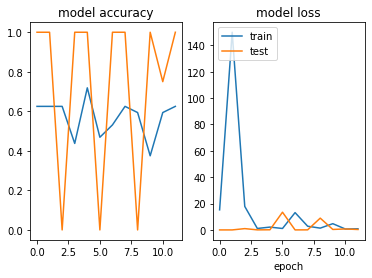

[ 0  1  2  3  4  5  6  7  8  9 10 11 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47]
[12 13 14 15 16 17 18 19 20 21 22 23]
1/1 [==============================] - 0s 127ms/step - loss: 0.7785 - accuracy: 0.4167
results: [0.0, 0.4166666567325592]


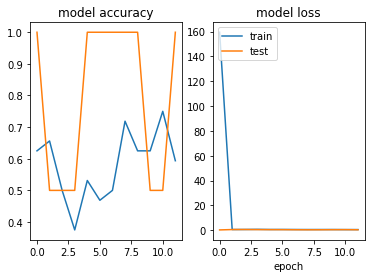

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 36 37 38 39 40 41 42 43 44 45 46 47]
[24 25 26 27 28 29 30 31 32 33 34 35]
1/1 [==============================] - 0s 130ms/step - loss: 0.6120 - accuracy: 0.6667
results: [0.0, 0.4166666567325592, 0.6666666865348816]


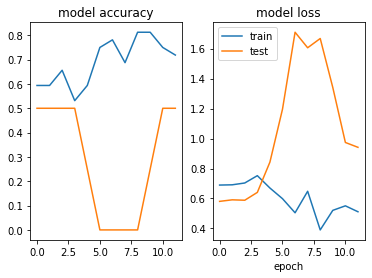

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47]
1/1 [==============================] - 0s 126ms/step - loss: 0.9699 - accuracy: 0.0833
results: [0.0, 0.4166666567325592, 0.6666666865348816, 0.0833333358168602]


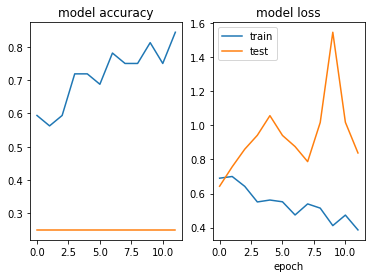

1/1 [==============================] - 0s 180ms/step - loss: 0.7558 - accuracy: 0.5000

Validation using the holdout data: [0.7557980418205261, 0.5]


In [ ]:
custom_kfold(X, y, custom_VGG19(), "VGG19")

Holdout: 
(12, 224, 224, 3)
[0 0 0 0 0 0 1 1 1 1 1 1]
Inicialmente balanceado.
Current fold: 1
1/1 [==============================] - 1s 943ms/step - loss: 26.1874 - accuracy: 0.0000e+00


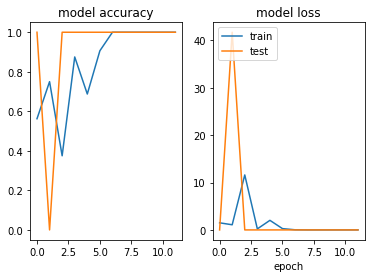

Current fold: 2
1/1 [==============================] - 0s 74ms/step - loss: 2.0857 - accuracy: 0.4167


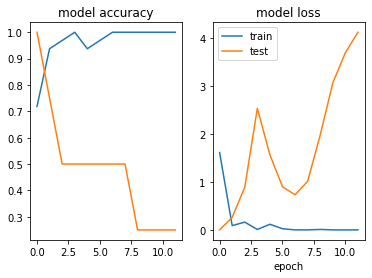

Current fold: 3
1/1 [==============================] - 0s 71ms/step - loss: 2.9588 - accuracy: 0.3333


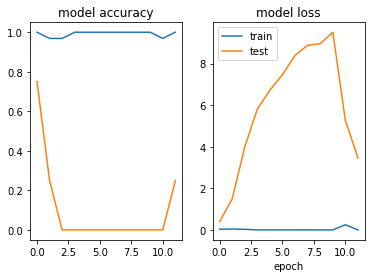

Current fold: 4
1/1 [==============================] - 0s 72ms/step - loss: 0.0170 - accuracy: 1.0000


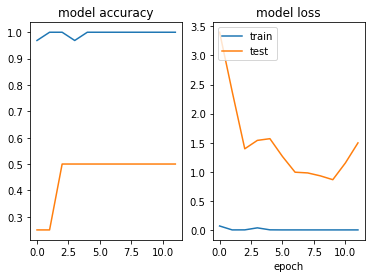

1/1 [==============================] - 1s 545ms/step - loss: 0.5926 - accuracy: 0.7500

Validation using the holdout data: [0.5925644040107727, 0.75]


In [ ]:
custom_kfold(X, y, custom_InceptionV3(), "Incep")
#custom_InceptionV3().summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

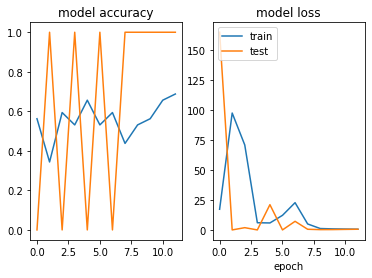

Current fold: 2
1/1 [==============================] - 0s 109ms/step - loss: 0.1743 - accuracy: 1.0000


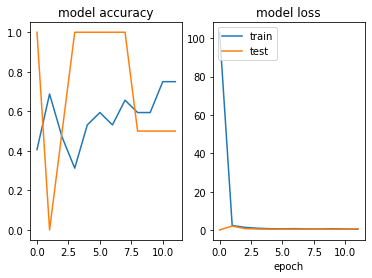

Current fold: 3
1/1 [==============================] - 0s 109ms/step - loss: 1.1657 - accuracy: 0.0833


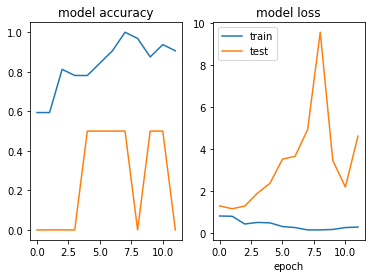

Current fold: 4
1/1 [==============================] - 0s 117ms/step - loss: 1.3700 - accuracy: 0.2500


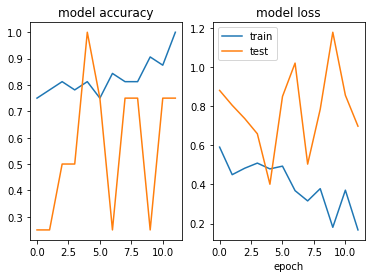

1/1 [==============================] - 0s 165ms/step - loss: 2.1892 - accuracy: 0.2500

Validation using the holdout data: [2.189246892929077, 0.25]


In [ ]:
custom_kfold(X, y, custom_ResNet50V2(), "ResNet")
# print(custom_ResNet50V2().summary())

Verificar pra fazer algo customizado e alterar o classiicador por meio de um laço, fica bala

Antes tava fazendo 50% treino e 50% teste, por isso o 0.333333...

> Mount e Defines

>  Funções que abrem a imagem

> *   openImgs()
*   join()
*   joi_open_file()
*   def VGG16(), InceptionV3() e ResNet50V2()
*   chamadas das redes usando o Leave-One-Out
*   chamada dos summary() das redes

> Problemas não resolvidos
* Fazer uma descrição de cada rede



> Problemas resolvidos

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.333
session = InteractiveSession(config=config)

# model code as usual down here